In [3]:
import math

class Cluster:
    """
    Class for creating and merging clusters of counties
    """
    
    def __init__(self, fips_codes, horiz_pos, vert_pos, population, risk):
        """
        Create a cluster based the models a set of counties' data
        """
        self._fips_codes = fips_codes
        self._horiz_center = horiz_pos
        self._vert_center = vert_pos
        self._total_population = population
        self._averaged_risk = risk
        
        
    def __repr__(self):
        """
        String representation assuming the module is "alg_cluster".
        """
        rep = "alg_cluster.Cluster("
        rep += str(self._fips_codes) + ", "
        rep += str(self._horiz_center) + ", "
        rep += str(self._vert_center) + ", "
        rep += str(self._total_population) + ", "
        rep += str(self._averaged_risk) + ")"
        return rep


    def fips_codes(self):
        """
        Get the cluster's set of FIPS codes
        """
        return self._fips_codes
    
    def horiz_center(self):
        """
        Get the averged horizontal center of cluster
        """
        return self._horiz_center
    
    def vert_center(self):
        """
        Get the averaged vertical center of the cluster
        """
        return self._vert_center
    
    def total_population(self):
        """
        Get the total population for the cluster
        """
        return self._total_population
    
    def averaged_risk(self):
        """
        Get the averaged risk for the cluster
        """
        return self._averaged_risk
   
        
    def copy(self):
        """
        Return a copy of a cluster
        """
        copy_cluster = Cluster(set(self._fips_codes), self._horiz_center, self._vert_center,
                               self._total_population, self._averaged_risk)
        return copy_cluster


    def distance(self, other_cluster):
        """
        Compute the Euclidean distance between two clusters
        """
        vert_dist = self._vert_center - other_cluster.vert_center()
        horiz_dist = self._horiz_center - other_cluster.horiz_center()
        return math.sqrt(vert_dist ** 2 + horiz_dist ** 2)
        
    def merge_clusters(self, other_cluster):
        """
        Merge one cluster into another
        The merge uses the relatively populations of each
        cluster in computing a new center and risk
        
        Note that this method mutates self
        """
        if len(other_cluster.fips_codes()) == 0:
            return self
        else:
            self._fips_codes.update(set(other_cluster.fips_codes()))
 
            # compute weights for averaging
            self_weight = float(self._total_population)                        
            other_weight = float(other_cluster.total_population())
            self._total_population = self._total_population + other_cluster.total_population()
            self_weight /= self._total_population
            other_weight /= self._total_population
                    
            # update center and risk using weights
            self._vert_center = self_weight * self._vert_center + other_weight * other_cluster.vert_center()
            self._horiz_center = self_weight * self._horiz_center + other_weight * other_cluster.horiz_center()
            self._averaged_risk = self_weight * self._averaged_risk + other_weight * other_cluster.averaged_risk()
            return self

    def cluster_error(self, data_table):
        """
        Input: data_table is the original table of cancer data used in creating the cluster.
        
        Output: The error as the sum of the square of the distance from each county
        in the cluster to the cluster center (weighted by its population)
        """
        # Build hash table to accelerate error computation
        fips_to_line = {}
        for line_idx in range(len(data_table)):
            line = data_table[line_idx]
            fips_to_line[line[0]] = line_idx
        
        # compute error as weighted squared distance from counties to cluster center
        total_error = 0
        counties = self.fips_codes()
        for county in counties:
            line = data_table[fips_to_line[county]]
            singleton_cluster = Cluster(set([line[0]]), line[1], line[2], line[3], line[4])
            singleton_distance = self.distance(singleton_cluster)
            total_error += (singleton_distance ** 2) * singleton_cluster.total_population()
        return total_error
    

In [39]:
#http://www.codeskulptor.org/#user46_8QMFuPCcJT_63.py
"""
Student template code for Project 3
Student will implement five functions:

slow_closest_pair(cluster_list)
fast_closest_pair(cluster_list)
closest_pair_strip(cluster_list, horiz_center, half_width)
hierarchical_clustering(cluster_list, num_clusters)
kmeans_clustering(cluster_list, num_clusters, num_iterations)

where cluster_list is a 2D list of clusters in the plane
"""

#import math
#import alg_cluster

######################################################
# Code for closest pairs of clusters

def pair_distance(cluster_list, idx1, idx2):
    """
    Helper function that computes Euclidean distance between two clusters in a list

    Input: cluster_list is list of clusters, idx1 and idx2 are integer indices for two clusters
    
    Output: tuple (dist, idx1, idx2) where dist is distance between
    cluster_list[idx1] and cluster_list[idx2]
    """

    return (cluster_list[idx1].distance(cluster_list[idx2]), min(idx1, idx2), max(idx1, idx2))


def slow_closest_pair(cluster_list):
    """
    Compute the distance between the closest pair of clusters in a list (slow)

    Input: cluster_list is the list of clusters
    
    Output: tuple of the form (dist, idx1, idx2) where the centers of the clusters
    cluster_list[idx1] and cluster_list[idx2] have minimum distance dist.       
    """
    result = (float("inf"), -1, -1)
    length = len(cluster_list)
    dist = float("inf")
    for dummy_i in range(length):
        for dummy_j in range(dummy_i+1,length, 1):
            dist_computed = pair_distance(cluster_list, dummy_i, dummy_j)[0]
            if dist_computed < dist:
                dist = dist_computed
                result = (dist, dummy_i, dummy_j)
    
    return result

def closest_pair_strip(cluster_list, horiz_center, half_width):
    """
    Helper function to compute the closest pair of clusters in a vertical strip
    
    Input: cluster_list is a list of clusters produced by fast_closest_pair
    horiz_center is the horizontal position of the strip's vertical center line
    half_width is the half the width of the strip (i.e; the maximum horizontal distance
    that a cluster can lie from the center line)

    Output: tuple of the form (dist, idx1, idx2) where the centers of the clusters
    cluster_list[idx1] and cluster_list[idx2] lie in the strip and have minimum distance dist.       
    """
    strip_set = []
    left = horiz_center - half_width
    right = horiz_center + half_width
    
    for idx in range(len(cluster_list)):
        if left < cluster_list[idx].horiz_center() and cluster_list[idx].horiz_center()< right:
            strip_set.append(idx)
    strip_set.sort(key = lambda idx: cluster_list[idx].vert_center())       
    length = len(strip_set)
    dist = (float("inf"), -1, -1)
    
    for dummy_i in range(length-1):
        val = min(dummy_i+4, length)
        for dummy_j in range(dummy_i+1,val):
            dist_compute = pair_distance(cluster_list, strip_set[dummy_i], strip_set[dummy_j])       
            if dist_compute[0] < dist[0]:
                dist = (dist_compute[0], min(strip_set[dummy_i],strip_set[dummy_j]), max(strip_set[dummy_i],strip_set[dummy_j]))

    return dist

def fast_closest_pair(cluster_list):
    """
    Compute the distance between the closest pair of clusters in a list (fast)

    Input: cluster_list is list of clusters SORTED such that horizontal positions of their
    centers are in ASCENDING order
    
    Output: tuple of the form (dist, idx1, idx2) where the centers of the clusters
    cluster_list[idx1] and cluster_list[idx2] have minimum distance dist.       
    """
    length = len(cluster_list)
    
    if length <= 3:
        return slow_closest_pair(cluster_list)
    else:
        cluster_list.sort(key = lambda cluster_list: cluster_list.horiz_center())
        num = int(math.floor(length/2))
        pl_set = cluster_list[:num]
        pr_set = cluster_list[num:]
        dist_pl = fast_closest_pair(pl_set)
        dist_pr = fast_closest_pair(pr_set) 
        if min(dist_pl[0], dist_pr[0]) == dist_pl[0]:
            result = dist_pl
        else:
            result = (dist_pr[0], dist_pr[1]+num, dist_pr[2]+num)
        
        mid = (cluster_list[num-1].horiz_center()+cluster_list[num].horiz_center())/2
        
        dist_pair_strip = closest_pair_strip(cluster_list, mid,result[0])
        if dist_pair_strip[0]<result[0]:
            return dist_pair_strip
        else:
            return result

######################################################################
# Code for hierarchical clustering

def hierarchical_clustering(cluster_list, num_clusters):
    """
    Compute a hierarchical clustering of a set of clusters
    Note: the function mutates cluster_list
    
    Input: List of clusters, number of clusters
    Output: List of clusters whose length is num_clusters
    """
    while len(cluster_list) > num_clusters:
        closest_pair = fast_closest_pair(cluster_list)
        cluster_i, cluster_j = cluster_list[closest_pair[1]],cluster_list[closest_pair[2]]
        cluster_i_j = cluster_i.merge_clusters(cluster_j)
        cluster_list.append(cluster_i_j)
        cluster_list.remove(cluster_i)
        cluster_list.remove(cluster_j)
    return cluster_list


######################################################################
# Code for k-means clustering

    
def kmeans_clustering(cluster_list, num_clusters, num_iterations):
    """
    Compute the k-means clustering of a set of clusters
    Note: the function may not mutate cluster_list
    
    Input: List of clusters, integers number of clusters and number of iterations
    Output: List of clusters whose length is num_clusters
    """
    #length_n = len(cluster_list)
    center_list=[(cluster_list[index].total_population(),index) for index in range(len(cluster_list))]# index -> cluster_list[index] has the corresponding population
    center_list.sort(reverse=True) # Sort based upon population
    center_list = [item[1] for item in center_list[:num_clusters]] #get index to cluster_list
    center_list = [cluster_list[index] for index in center_list]

    #Below starting line 3
    for dummy_i in range(num_iterations):
        #initialize k empty sets C1...Ck
        set_c = [Cluster(set([]),center.horiz_center(),center.vert_center(),0, 0.0) for center in center_list]
        saving_list = [Cluster(set([]),center.horiz_center(),center.vert_center(),0, 0.0) for center in center_list]
        for dummy_j in range(len(cluster_list)):
            dist=float("inf")
            set_c_index = -1
            for num in range(num_clusters):  
                dist_compute = cluster_list[dummy_j].distance(set_c[num])
                if dist_compute < dist:
                    dist = dist_compute
                    set_c_index = num
            saving_list[set_c_index].merge_clusters(cluster_list[dummy_j])
     
        center_list = [saving_list[num] for num in range(num_clusters)]
   
    return saving_list


In [13]:
#test
a = [Cluster(set([]), 0, 0, 0, 0.0), Cluster(set(['1', '01073']), 1.5, 0.0, 4, 0.0),Cluster(set(['2']), 2.0, 1.0, 0, 0.0),Cluster(set(['3']), 12.0, 10.0, 2, 0.0),]
print kmeans_clustering(a, 2, 2)

[alg_cluster.Cluster(set(['1', '2', '01073']), 1.5, 0.0, 4, 0.0), alg_cluster.Cluster(set(['3']), 12.0, 10.0, 2, 0.0)]


0.4463145542147069

# Question 1

In [5]:
import random
import time
import matplotlib.pyplot as plt

In [6]:
def gen_random_clusters(num_clusters):
    """
    Creates a list of clusters where each cluster 
    in this list corresponds to one randomly generated 
    point in the square with corners(±1,±1)
    """
    cluster_list = []
    for dummy_i in range(num_clusters):
        cluster_list.append(Cluster(set([]), random.random(), random.random(), 0, 0.0))
    return cluster_list

In [7]:
def time_simulation():
    """
    Measure running time of two functions 
    with different number of initial clusters
    """
    slow = []
    fast = []
    
    for n in range(2, 200, 2):
        start = time.time()
        cluster_list = gen_random_clusters(n)
        slow_closest_pair(cluster_list)
        end = time.time()
        slow.append(end-start)
    
    for n in range(2, 200, 2):
        start = time.time()
        cluster_list = gen_random_clusters(n)
        fast_closest_pair(cluster_list)
        end = time.time()
        fast.append(end-start)        
          
    return slow, fast

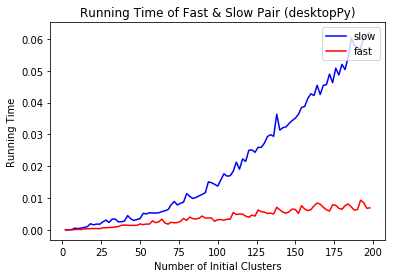

In [54]:
def graph_running_time():
    """
    Plot run_time curve by two different algorithms: slow & fast_closest_pair(cluster_list)
    x-axis is the initial number of clusters
    """
    initial_cluster = range(2, 200, 2)
    slow, fast = time_simulation()

    plt.plot(initial_cluster, slow, '-b', label='slow')
    plt.plot(initial_cluster, fast, '-r', label='fast')
    plt.legend(loc='upper right')
    plt.title("Running Time of Fast & Slow Pair (desktopPy)")
    plt.xlabel('Number of Initial Clusters')
    plt.ylabel('Running Time')
    plt.show()

graph_running_time()

# Question 2


In [10]:
"""
Some provided code for plotting the clusters using matplotlib
#alg_clusters_matplotlib.py
"""

import math
import urllib2
import matplotlib.pyplot as plt


# URLS for various important datasets
DIRECTORY = "http://commondatastorage.googleapis.com/codeskulptor-assets/"
MAP_URL = DIRECTORY + "data_clustering/USA_Counties.png"

# Define colors for clusters.  Display a max of 16 clusters.
COLORS = ['Aqua', 'Yellow', 'Blue', 'Fuchsia', 'Black', 'Green', 'Lime', 'Maroon', 'Navy', 'Olive', 'Orange', 'Purple', 'Red', 'Brown', 'Teal']



# Helper functions

def circle_area(pop):
    """
    Compute area of circle proportional to population
    """
    return math.pi * pop / (200.0 ** 2)


def plot_clusters(data_table, cluster_list, draw_centers = False):
    """
    Create a plot of clusters of counties
    """

    fips_to_line = {}
    for line_idx in range(len(data_table)):
        fips_to_line[data_table[line_idx][0]] = line_idx
     
    # Load map image
    map_file = urllib2.urlopen(MAP_URL)
    map_img = plt.imread(map_file)

    # Scale plot to get size similar to CodeSkulptor version
    ypixels, xpixels, bands = map_img.shape
    DPI = 60.0                  # adjust this constant to resize your plot
    xinch = xpixels / DPI
    yinch = ypixels / DPI
    plt.figure(figsize=(xinch,yinch))
    implot = plt.imshow(map_img)
   
    # draw the counties colored by cluster on the map
    if not draw_centers:
        for cluster_idx in range(len(cluster_list)):
            cluster = cluster_list[cluster_idx]
            cluster_color = COLORS[cluster_idx % len(COLORS)]
            for fips_code in cluster.fips_codes():
                line = data_table[fips_to_line[fips_code]]
                plt.scatter(x = [line[1]], y = [line[2]], s =  circle_area(line[3]), lw = 1,
                            facecolors = cluster_color, edgecolors = cluster_color)

    # add cluster centers and lines from center to counties            
    else:
        for cluster_idx in range(len(cluster_list)):
            cluster = cluster_list[cluster_idx]
            cluster_color = COLORS[cluster_idx % len(COLORS)]
            for fips_code in cluster.fips_codes():
                line = data_table[fips_to_line[fips_code]]
                plt.scatter(x = [line[1]], y = [line[2]], s =  circle_area(line[3]), lw = 1,
                            facecolors = cluster_color, edgecolors = cluster_color, zorder = 1)
        for cluster_idx in range(len(cluster_list)):
            cluster = cluster_list[cluster_idx]
            cluster_color = COLORS[cluster_idx % len(COLORS)]
            cluster_center = (cluster.horiz_center(), cluster.vert_center())
            for fips_code in cluster.fips_codes():
                line = data_table[fips_to_line[fips_code]]
                plt.plot( [cluster_center[0], line[1]],[cluster_center[1], line[2]], cluster_color, lw=1, zorder = 2)
        for cluster_idx in range(len(cluster_list)):
            cluster = cluster_list[cluster_idx]
            cluster_color = COLORS[cluster_idx % len(COLORS)]
            cluster_center = (cluster.horiz_center(), cluster.vert_center())
            cluster_pop = cluster.total_population()
            plt.scatter(x = [cluster_center[0]], y = [cluster_center[1]], s =  circle_area(cluster_pop), lw = 2,
                        facecolors = "none", edgecolors = "black", zorder = 3)


    plt.show()

In [11]:
"""
#alg_project3_viz.py
Example code for creating and visualizing
cluster of county-based cancer risk data

Note that you must download the file
http://www.codeskulptor.org/#alg_clusters_matplotlib.py
to use the matplotlib version of this code
"""

# Flavor of Python - desktop or CodeSkulptor
DESKTOP = True

import math
import random
import urllib2
#import alg_cluster

# conditional imports
# if DESKTOP:
#     #import alg_project3_solution      # desktop project solution
#     #import alg_clusters_matplotlib
# else:
#     #import userXX_XXXXXXXX as alg_project3_solution   # CodeSkulptor project solution
#     import alg_clusters_simplegui
#     import codeskulptor
#     codeskulptor.set_timeout(30)


###################################################
# Code to load data tables

# URLs for cancer risk data tables of various sizes
# Numbers indicate number of counties in data table

DIRECTORY = "http://commondatastorage.googleapis.com/codeskulptor-assets/"
DATA_3108_URL = DIRECTORY + "data_clustering/unifiedCancerData_3108.csv"
DATA_896_URL = DIRECTORY + "data_clustering/unifiedCancerData_896.csv"
DATA_290_URL = DIRECTORY + "data_clustering/unifiedCancerData_290.csv"
DATA_111_URL = DIRECTORY + "data_clustering/unifiedCancerData_111.csv"


def load_data_table(data_url):
    """
    Import a table of county-based cancer risk data
    from a csv format file
    """
    data_file = urllib2.urlopen(data_url)
    data = data_file.read()
    data_lines = data.split('\n')
    print "Loaded", len(data_lines), "data points"
    data_tokens = [line.split(',') for line in data_lines]
    return [[tokens[0], float(tokens[1]), float(tokens[2]), int(tokens[3]), float(tokens[4])] 
            for tokens in data_tokens]


############################################################
# Code to create sequential clustering
# Create alphabetical clusters for county data

def sequential_clustering(singleton_list, num_clusters):
    """
    Take a data table and create a list of clusters
    by partitioning the table into clusters based on its ordering
    
    Note that method may return num_clusters or num_clusters + 1 final clusters
    """
    
    cluster_list = []
    cluster_idx = 0
    total_clusters = len(singleton_list)
    cluster_size = float(total_clusters)  / num_clusters
    
    for cluster_idx in range(len(singleton_list)):
        new_cluster = singleton_list[cluster_idx]
        if math.floor(cluster_idx / cluster_size) != \
           math.floor((cluster_idx - 1) / cluster_size):
            cluster_list.append(new_cluster)
        else:
            cluster_list[-1] = cluster_list[-1].merge_clusters(new_cluster)
            
    return cluster_list

Loaded 3108 data points
Displaying 15 hierarchical clusters


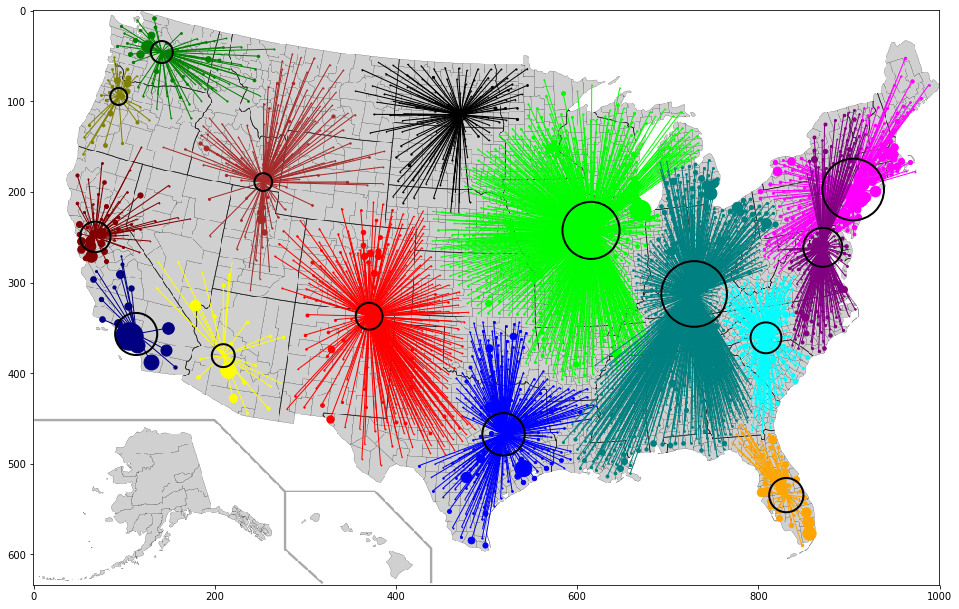

In [36]:
#####################################################################
# Code to load cancer data, compute a hierarchical clustering and 
# visualize the results  3018 dataset with 15 clusters

def run_example():
    """
    Load a data table, compute a list of clusters and 
    plot a list of clusters

    Set DESKTOP = True/False to use either matplotlib or simplegui
    """
    data_table = load_data_table(DATA_3108_URL)
    
    singleton_list = []
    for line in data_table:
        singleton_list.append(Cluster(set([line[0]]), line[1], line[2], line[3], line[4]))
   
   #cluster_list = sequential_clustering(singleton_list, 15)	
   #print "Displaying", len(cluster_list), "sequential clusters"

    cluster_list = hierarchical_clustering(singleton_list, 15)
    print "Displaying", len(cluster_list), "hierarchical clusters"

    #cluster_list = alg_project3_solution.kmeans_clustering(singleton_list, 9, 5)	
    #print "Displaying", len(cluster_list), "k-means clusters"

    DESKTOP = True       
    # draw the clusters using matplotlib or simplegui
    if DESKTOP:
        #plot_clusters(data_table, cluster_list, False)
        plot_clusters(data_table, cluster_list, True)  #add cluster centers
    else:
        alg_clusters_simplegui.PlotClusters(data_table, cluster_list)   # use toggle in GUI to add cluster centers
    
run_example()

# Question 3

Use alg_project3_viz to create an image of the 1515 clusters 
generated by applying 55 iterations of k-means clustering 
to the 31083108 county cancer risk data set. 

Loaded 3108 data points
Displaying 15 k-means clusters


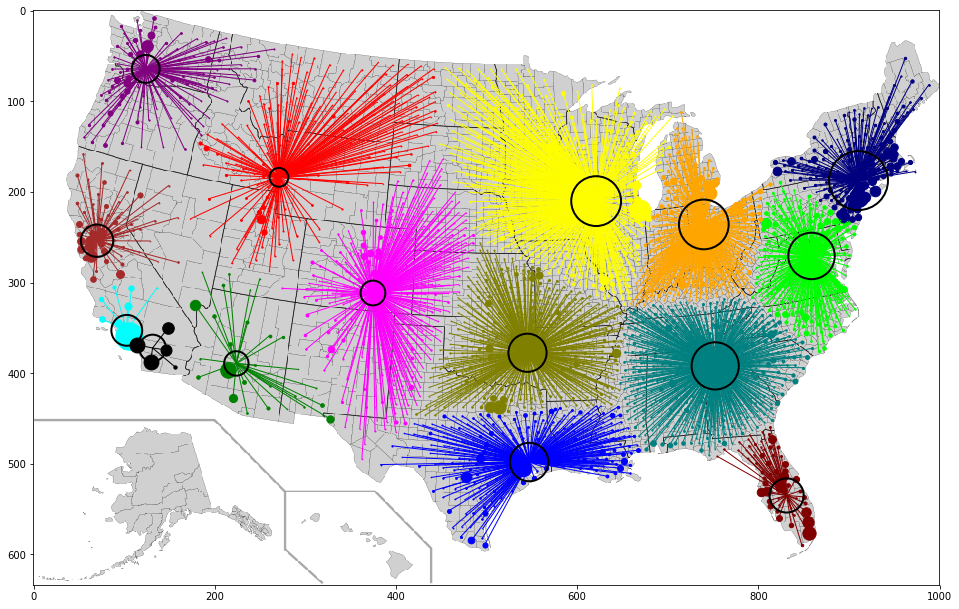

In [37]:
def run_example2():
    """
    Load a data table, compute a list of clusters and 
    plot a list of clusters

    Set DESKTOP = True/False to use either matplotlib or simplegui
    """
    data_table = load_data_table(DATA_3108_URL)
    
    singleton_list = []
    for line in data_table:
        singleton_list.append(Cluster(set([line[0]]), line[1], line[2], line[3], line[4]))
   
   #cluster_list = sequential_clustering(singleton_list, 15)	
   #print "Displaying", len(cluster_list), "sequential clusters"

    #cluster_list = hierarchical_clustering(singleton_list, 15)
    #print "Displaying", len(cluster_list), "hierarchical clusters"

    cluster_list = kmeans_clustering(singleton_list,15, 5)	
    print "Displaying", len(cluster_list), "k-means clusters"

            
    # draw the clusters using matplotlib or simplegui
    if DESKTOP:
        #plot_clusters(data_table, cluster_list, False)
        plot_clusters(data_table, cluster_list, True)  #add cluster centers
    else:
        alg_clusters_simplegui.PlotClusters(data_table, cluster_list)   # use toggle in GUI to add cluster centers
    
run_example2()

# Question 4

For the worst case running time, hierarchical is O(n(n-k)log(n^2))--> O(nlog(n^2)), and kmeans qnk->nk for a small value q; 
Because n>>k, kmeans is much faster.

# Question 5

Loaded 111 data points
Displaying 9 hierarchical clusters


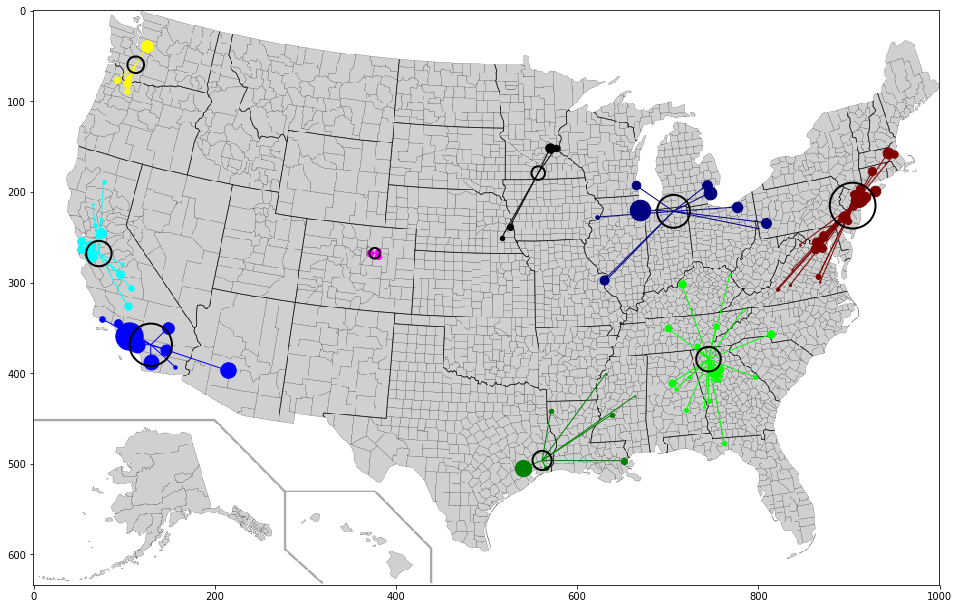

In [45]:
#hierarchical_clustering, 9 clusters
def run_example3():
    """
    Load a data table, compute a list of clusters and 
    plot a list of clusters

    Set DESKTOP = True/False to use either matplotlib or simplegui
    """
    data_table = load_data_table(DATA_111_URL)
    
    singleton_list = []
    for line in data_table:
        singleton_list.append(Cluster(set([line[0]]), line[1], line[2], line[3], line[4]))
   
   #cluster_list = sequential_clustering(singleton_list, 15)	
   #print "Displaying", len(cluster_list), "sequential clusters"

    cluster_list = hierarchical_clustering(singleton_list, 9)
    print "Displaying", len(cluster_list), "hierarchical clusters"

    #cluster_list = kmeans_clustering(singleton_list,15, 5)	
    #print "Displaying", len(cluster_list), "k-means clusters"

    DESKTOP = True        
    # draw the clusters using matplotlib or simplegui
    if DESKTOP:
        #plot_clusters(data_table, cluster_list, False)
        plot_clusters(data_table, cluster_list, True)  #add cluster centers
    else:
        alg_clusters_simplegui.PlotClusters(data_table, cluster_list)   # use toggle in GUI to add cluster centers
        
run_example3()

# Question 6

Loaded 111 data points
Displaying 9 k-means clusters


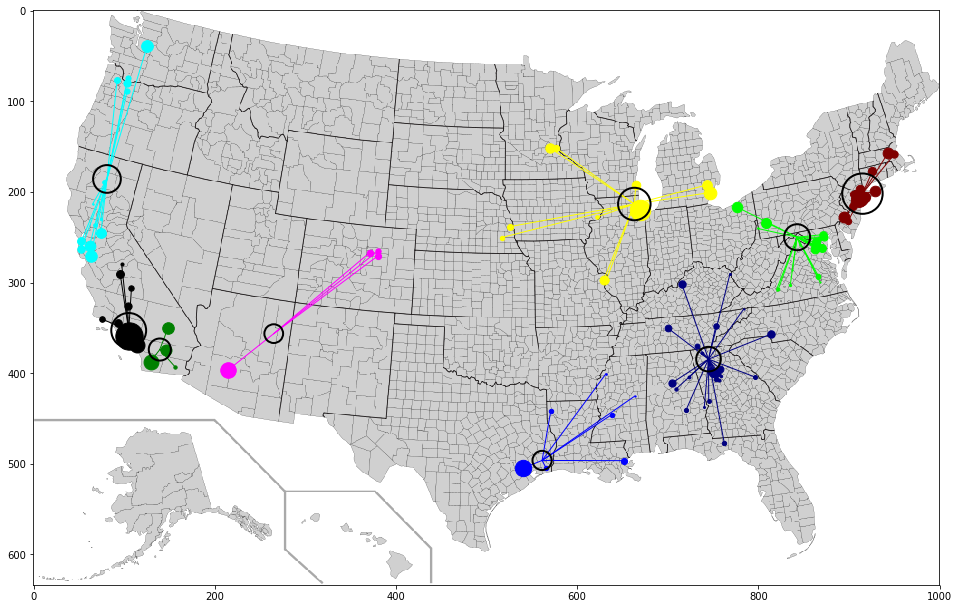

In [39]:
# k-means clustering, 9 clusters, 5 iterations
def run_example4():
    """
    Load a data table, compute a list of clusters and 
    plot a list of clusters

    Set DESKTOP = True/False to use either matplotlib or simplegui
    """
    data_table = load_data_table(DATA_111_URL)
    
    singleton_list = []
    for line in data_table:
        singleton_list.append(Cluster(set([line[0]]), line[1], line[2], line[3], line[4]))
   
   #cluster_list = sequential_clustering(singleton_list, 15)	
   #print "Displaying", len(cluster_list), "sequential clusters"

    #cluster_list = hierarchical_clustering(singleton_list, 9)
    #print "Displaying", len(cluster_list), "hierarchical clusters"

    cluster_list = kmeans_clustering(singleton_list,9, 5)	
    print "Displaying", len(cluster_list), "k-means clusters"

            
    # draw the clusters using matplotlib or simplegui
    if DESKTOP:
        #plot_clusters(data_table, cluster_list, False)
        plot_clusters(data_table, cluster_list, True)  #add cluster centers
    else:
        alg_clusters_simplegui.PlotClusters(data_table, cluster_list)   # use toggle in GUI to add cluster centers
        
run_example4()

# Question 7

In [55]:
"""
Compute distortion
"""
def compute_distortion(hierarchical = True):
    """
    Compute distortion of two lists from Q5 and Q6;
    Return two distortion values.
    """ 
    data_table = load_data_table(DATA_111_URL)
    
    singleton_list = []
    for line in data_table:
        singleton_list.append(Cluster(set([line[0]]), line[1], line[2], line[3], line[4]))
    
    if hierarchical:
        cluster_list = hierarchical_clustering(singleton_list, 9)   
    else:
        cluster_list = kmeans_clustering(singleton_list,9, 5)
    
    #copied = [cluster.copy() for cluster in cluster_list]
    total_error = sum([cluster.cluster_error(data_table) for cluster in cluster_list])

    return total_error      

In [56]:
hierarchical_error = compute_distortion(hierarchical = True) 
kmeans_error = compute_distortion(hierarchical = False)
print "hierarchical: "+str(hierarchical_error)
print "k-means: "+str(kmeans_error)

Loaded 111 data points
Loaded 111 data points
hierarchical: 1.75163886916e+11
k-means: 2.71254226924e+11


# Question 8

Describe the difference between the shapes of the clusters produced by these two methods on the west coast of the USA. 
Two methods both produce three clusters on west coast. Hierarchical generates initial cluster by the distance closeness whereas k-means generates by total population. Thus we see on hierarchical graph, Seattle and San Francisco are two separated clusters because they are far apart; San Diego and Los Angeles are merged into one cluster becasue they are very close. On k-means graph, LA, SF and SD are three initial clusters because population size on West Coast is: LA > SD > SF > Seattle. Seattle merge with SF because it is Seattle's closest cluster.

# Question 9

Which one requires less human supervision to produce clusterings with relatively low distortion?
hierarchical clustering

# Question 10

In [41]:
# Analyze quality of two methods by distortion value
def compute_distortion2(data_set, hierarchical = True):
    """
    Compute distortion value of different output clusters;
    Return distortion list.
    """ 
    distortion_list= []
    data_table = load_data_table(data_set)
    
    singleton_list = []
    for line in data_table:
        singleton_list.append(Cluster(set([line[0]]), line[1], line[2], line[3], line[4]))
    
    if hierarchical:
        #change number of output clusters [6,20]
        #get initial cluster of 20 for hierarchical
        cluster_list = hierarchical_clustering(singleton_list, 20)
        distortion_list.append(sum([cluster.cluster_error(data_table) for cluster in cluster_list]))
        
        for num in range(19,5,-1):
            cluster_list = hierarchical_clustering(cluster_list, num)
            distortion_list.append(sum([cluster.cluster_error(data_table) for cluster in cluster_list]))
        distortion_list.reverse()
        return distortion_list
    else:
        for num in range(6,21,1):
            cluster_list = kmeans_clustering(singleton_list,num, 5)
            distortion_list.append(sum([cluster.cluster_error(data_table) for cluster in cluster_list]))
        return distortion_list

In [42]:
def graph_distortion(data_set,title):
    """
    Plot distortion curve by two different algorithms
    x-axis is number of output clusters
    """
    num_cluster = range(6,21,1)
    
    kmeans_list = compute_distortion2(data_set, hierarchical = False)
    hierarchical_list = compute_distortion2(data_set, hierarchical = True)

    plt.plot(num_cluster, kmeans_list, '-b', label='kmeans')
    plt.plot(num_cluster, hierarchical_list, '-r', label='hierarchical')
    plt.legend(loc='upper right')
    plt.title(title)
    plt.xlabel('Number of Output Clusters')
    plt.ylabel('Distortion Value')
    plt.show()

Loaded 111 data points
Loaded 111 data points


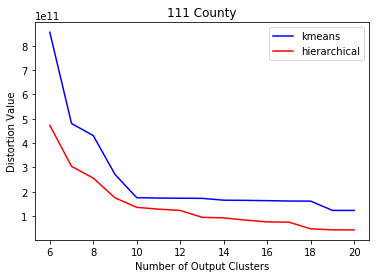

In [46]:
graph_distortion(DATA_111_URL,'111 County')

Loaded 290 data points
Loaded 290 data points


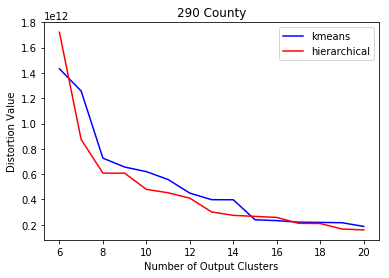

In [48]:
graph_distortion(DATA_290_URL,'290 County')

Loaded 896 data points
Loaded 896 data points


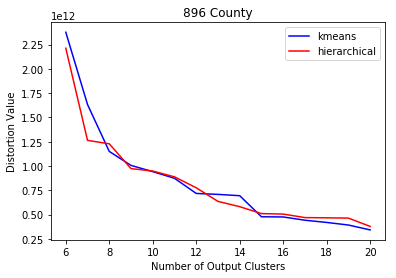

In [49]:
graph_distortion(DATA_896_URL,'896 County')

# Question 11

111 dataset: hierarchical is better
290 dataset: hierarchical is better in general
896 dataset: both produce almost same results.

# Overall Evaluation

For smaller datasets, e.g. 111 and 290 county, hierarchical method is better. The datasets of smaller size produce sparse graph and can be a good fit to distance-based hierarchical method. From 111 to 896 county datasets, we see a trend that k-means gets better performance as the number of output clusters increases or the data size increases. In fact, k-means performs better when we use 896 dataset with output cluster = 25, as shown in the test below.
To summarize, for smaller dataset and small number of output clusters, hierarchical is good, i.e. lower distortion value. For bigger dataset and larger number of output clusters, k-means performs better.

In [50]:
# Test
def compute_distortion3(data_set, hierarchical = True):
    """
    Compute distortion value of different output clusters;
    Return distortion list.
    """ 
    distortion_list= []
    data_table = load_data_table(data_set)
    
    singleton_list = []
    for line in data_table:
        singleton_list.append(Cluster(set([line[0]]), line[1], line[2], line[3], line[4]))
    
    if hierarchical:
        #change number of output clusters [6,20]
        #get initial cluster of 20 for hierarchical
        cluster_list = hierarchical_clustering(singleton_list, 25)
        distortion_list.append(sum([cluster.cluster_error(data_table) for cluster in cluster_list]))
        
        for num in range(24,9,-1):
            cluster_list = hierarchical_clustering(cluster_list, num)
            distortion_list.append(sum([cluster.cluster_error(data_table) for cluster in cluster_list]))
        distortion_list.reverse()
        return distortion_list
    else:
        for num in range(10,25,1):
            cluster_list = kmeans_clustering(singleton_list,num, 5)
            distortion_list.append(sum([cluster.cluster_error(data_table) for cluster in cluster_list]))
        return distortion_list

In [51]:
#test
def graph_distortion2(data_set,title):
    """
    Plot distortion curve by two different algorithms
    x-axis is number of output clusters
    """
    num_cluster = range(10,25,1)
    
    kmeans_list = compute_distortion3(data_set, hierarchical = False)
    hierarchical_list = compute_distortion2(data_set, hierarchical = True)

    plt.plot(num_cluster, kmeans_list, '-b', label='kmeans')
    plt.plot(num_cluster, hierarchical_list, '-r', label='hierarchical')
    plt.legend(loc='upper right')
    plt.title(title)
    plt.xlabel('Number of Output Clusters')
    plt.ylabel('Distortion Value')
    plt.show()

Loaded 896 data points
Loaded 896 data points


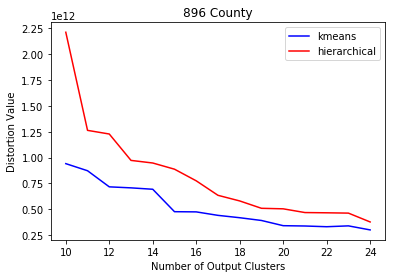

In [52]:
#test
graph_distortion2(DATA_896_URL,'896 County')